In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"]   = 12
import matplotlib.animation as animation 
from IPython import display 
from tqdm import tqdm
from pathlib import Path
from allensdk.brain_observatory.behavior.behavior_project_cache.behavior_neuropixels_project_cache import VisualBehaviorNeuropixelsProjectCache

In [ ]:
output_dir = r"C:\Users\farzadK\Desktop\hackathon_2024"

cache = VisualBehaviorNeuropixelsProjectCache.from_s3_cache(cache_dir=Path(output_dir))

# get the metadata tables
ecephys_sessions_table = cache.get_ecephys_session_table()
ecephys_sessions_table = ecephys_sessions_table[ecephys_sessions_table['experience_level']=='Familiar']   # Familiar with images
mouse_id = ecephys_sessions_table['mouse_id'].values
mice     = []
for id in range(len(np.unique(mouse_id))):
    mice.append(ecephys_sessions_table.index[np.where(mouse_id==np.unique(mouse_id)[id])[0]][0])

session       = mice[9]
Session       = cache.get_ecephys_session(ecephys_session_id=session)
units         = Session.get_units()
channels      = Session.get_channels()
unit_channels = units.merge(channels, left_on='peak_channel_id', right_index=True).sort_values('probe_vertical_position', ascending=False)

good_unit_filter = ((unit_channels['snr']>1)&
                    (unit_channels['isi_violations']<1)&
                    (unit_channels['firing_rate']>0.1))
good_units    = unit_channels.loc[good_unit_filter] 
good_units_V1 = good_units[good_units['structure_acronym']=='VISp']                 # V1 neurons
good_units_LM = good_units[good_units['structure_acronym']=='VISl']                 # LM neurons
good_units_AL = good_units[good_units['structure_acronym']=='VISal']                # LI neurons
good_units_RL = good_units[good_units['structure_acronym']=='VISrl']                # LM neurons
good_units_AM = good_units[good_units['structure_acronym']=='VISam']                # LM neurons
good_units_PM = good_units[good_units['structure_acronym']=='VISpm']                # LM neurons
all_units = [good_units_V1, good_units_LM, good_units_RL, good_units_AL, good_units_AM, good_units_PM]
ids_V1, ids_LM, ids_RL, ids_AL, ids_AM, ids_PM = [], [], [], [], [], []
for undex, unit in good_units_V1.iterrows():
    ids_V1.append(undex)
for undex, unit in good_units_LM.iterrows():
    ids_LM.append(undex)
for undex, unit in good_units_RL.iterrows():
    ids_RL.append(undex)
for undex, unit in good_units_AL.iterrows():
    ids_AL.append(undex)
for undex, unit in good_units_AM.iterrows():
    ids_AM.append(undex)
for undex, unit in good_units_PM.iterrows():
    ids_PM.append(undex)
all_ids = [ids_V1, ids_LM, ids_RL, ids_AL, ids_AM, ids_PM]

In [4]:
all_spike_times        = Session.spike_times
stimulus_presentations = Session.stimulus_presentations
stim_table_is_change   = stimulus_presentations[(stimulus_presentations['stimulus_block']==0) & (stimulus_presentations['is_change'])]  # active block
stim_table_pre_change  = stimulus_presentations[(stimulus_presentations['stimulus_block']==0) & ~(stimulus_presentations['is_change'])]  # active block

num_cells = len(all_spike_times)
is_change_stims  = stim_table_is_change['start_time'].values
pre_change_stims = stim_table_pre_change['start_time'].values

In [5]:
all_neurons = []
for area in all_ids:
    n = []
    for neuron in area:
        n.append(all_spike_times[neuron])
    all_neurons.append(n)

In [6]:
all_binned_spikes_is_change = []
for area in tqdm(all_neurons):
    binned_area = []
    for neuron in area:
        binned_spikes = np.zeros(250)
        for start in is_change_stims:
            trial_spike    = neuron[(neuron>=start) & (neuron<start+0.25)] - start
            binned_spikes += np.histogram(trial_spike, bins=np.arange(0, .251, .001))[0]
        binned_area.append(binned_spikes/len(is_change_stims))
    all_binned_spikes_is_change.append(np.array(binned_area))

all_binned_spikes_pre_change = []
for area in tqdm(all_neurons):
    binned_area = []
    for neuron in area:
        binned_spikes = np.zeros(250)
        for start in pre_change_stims:
            trial_spike    = neuron[(neuron>=start) & (neuron<start+0.25)] - start
            binned_spikes += np.histogram(trial_spike, bins=np.arange(0, .251, .001))[0]
        binned_area.append(binned_spikes/len(pre_change_stims))
    all_binned_spikes_pre_change.append(np.array(binned_area))

100%|██████████| 6/6 [01:36<00:00, 16.04s/it]


In [ ]:
areas = ['V1', 'LM', 'RL', 'AL', 'AM', 'PM']
for index, i in enumerate(all_binned_spikes_is_change):
    plt.plot(np.mean(i, axis=0)*1000, label=areas[index])
plt.xlabel('time from stimulus (ms)', fontsize=18)
plt.ylabel('average activity (spikes/s)', fontsize=18)
plt.title('average on is-change trials')
plt.legend()
plt.savefig(r"C:\Users\farzadK\Desktop\ischange.pdf", format='pdf')

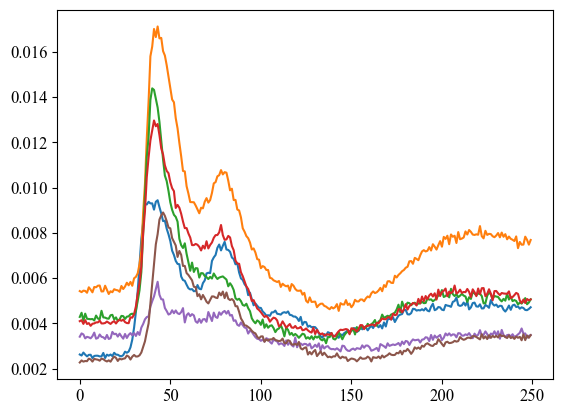

In [8]:
areas = ['V1', 'LM', 'RL', 'AL', 'AM', 'PM']
for index, i in enumerate(all_binned_spikes_pre_change):
    plt.plot(np.mean(i, axis=0)*1000, label=areas[index])
plt.xlabel('time from stimulus (ms)', fontsize=18)
plt.ylabel('average activity (spikes/s)', fontsize=18)
plt.title('average on pre-change trials')
plt.legend()
plt.savefig(r"C:\Users\farzadK\Desktop\prechange.pdf", format='pdf')

In [9]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

window_length, step = 40, 5
ims = []
for t in tqdm(range(0, 250-window_length, step)):
    corr_mat_is_change = np.zeros((6, 6))
    for andex1, area1 in enumerate(all_binned_spikes_is_change):
        for andex2, area2 in enumerate(all_binned_spikes_is_change[andex1:]):
            corr = 0
            for i in range(len(area1)):
                for j in range(len(area2)):
                    if np.isnan(np.corrcoef(area1[i][t:t+window_length], area2[j][t:t+window_length])[0, 1]):
                        continue
                    corr += np.corrcoef(area1[i][t:t+window_length], area2[j][t:t+window_length])[0, 1]
            if andex2 == 0:
                corr -= len(area1)
                corr_mat_is_change[andex1, andex1] = corr/(len(area1)*len(area1)-len(area1))
            else:
                corr_mat_is_change[andex1, andex2+andex1] = corr/(len(area1)*len(area2))
                corr_mat_is_change[andex2+andex1, andex1] = corr/(len(area1)*len(area2))

    corr_mat_pre_change = np.zeros((6, 6))
    for andex1, area1 in enumerate(all_binned_spikes_pre_change):
        for andex2, area2 in enumerate(all_binned_spikes_pre_change[andex1:]):
            corr = 0
            for i in range(len(area1)):
                for j in range(len(area2)):
                    if np.isnan(np.corrcoef(area1[i][t:t+window_length], area2[j][t:t+window_length])[0, 1]):
                        continue
                    corr += np.corrcoef(area1[i][t:t+window_length], area2[j][t:t+window_length])[0, 1]
            if andex2 == 0:
                corr -= len(area1)
                corr_mat_pre_change[andex1, andex1] = corr/(len(area1)*len(area1)-len(area1))
            else:
                corr_mat_pre_change[andex1, andex2+andex1] = corr/(len(area1)*len(area2))
                corr_mat_pre_change[andex2+andex1, andex1] = corr/(len(area1)*len(area2))

    ax1.set_xticks(np.arange(len(corr_mat_is_change[0])))  # Set the tick positions
    ax1.set_xticklabels(['V1', 'LM', 'RL', 'AL', 'AM', 'PM'])  # Set the tick labels
    ax1.set_yticks(np.arange(len(corr_mat_is_change)))
    ax1.set_yticklabels(['V1', 'LM', 'RL', 'AL', 'AM', 'PM'])
    ax1.tick_params(axis='x', labeltop=True, labelbottom=False)
    ax1.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    im1 = ax1.imshow(corr_mat_is_change, vmin=-.5, vmax=.5, cmap='inferno')

    ax2.set_xticks(np.arange(len(corr_mat_pre_change[0])))  # Set the tick positions
    ax2.set_xticklabels(['V1', 'LM', 'RL', 'AL', 'AM', 'PM'])  # Set the tick labels
    ax2.set_yticks(np.arange(len(corr_mat_pre_change)))
    ax2.set_yticklabels(['V1', 'LM', 'RL', 'AL', 'AM', 'PM'])
    ax2.tick_params(axis='x', labeltop=True, labelbottom=False)
    ax2.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    im2 = ax2.imshow(corr_mat_pre_change, vmin=-.5, vmax=.5, cmap='inferno')
    ims.append([im1, im2])

    
plt.close()
ani = animation.ArtistAnimation(fig, ims, interval=250, blit=True, repeat_delay=1000)

# Save the animation
ani.save(r'C:\Users\farzadK\Desktop\is_pre_change.mp4', fps=30, extra_args=['-vcodec', 'libx264'])
video = ani.to_html5_video() 

# embedding for the video 
html = display.HTML(video) 

# draw the animation 
display.display(html)
plt.close()

  0%|          | 0/42 [00:00<?, ?it/s]c:\Users\farzadK\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
c:\Users\farzadK\anaconda3\Lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
 50%|█████     | 21/42 [08:29<08:13, 23.48s/it]